# Import needed modules and useful functions

In [1]:
#-- necessary modules --#
import numpy as np
np.random.seed(13)
import pandas as pd
import torch
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
import matplotlib as mpl
from scipy import integrate
from scipy.optimize import curve_fit

#-- to computer fes --#
from mlcvs.utils.fes import compute_fes

#-- to run process from jupyter --#
import subprocess
import os
from pathlib import Path
# execute bash command in the given folder
def execute(command, folder, background=False):
    cmd = subprocess.run(command, cwd=folder, shell=True, capture_output = True, text=True, close_fds=background)
    if cmd.returncode == 0:
        print(f'Completed: {command}')
    else:
        print(cmd.stderr)

#-- python script for write correct input files for "ves_md_linearexpansion" plumed module --#
from input_VES import *
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'nstep':50000000, 
    'plumedseed':4525,
    'friction':10,
    'temp':0.5, #kbt units
    #-- upper basin --#
    #'initial_position':[0.6,0.02],
    #-- middle basin --#
    #'initial_position':[-0.05,0.47],
    #-- lower basin --#
    'initial_position':[-0.55,1.45],
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :16,
}
#--------------------------------------#

## M&uuml;ller Potential 
Just have a look at the Muller potential

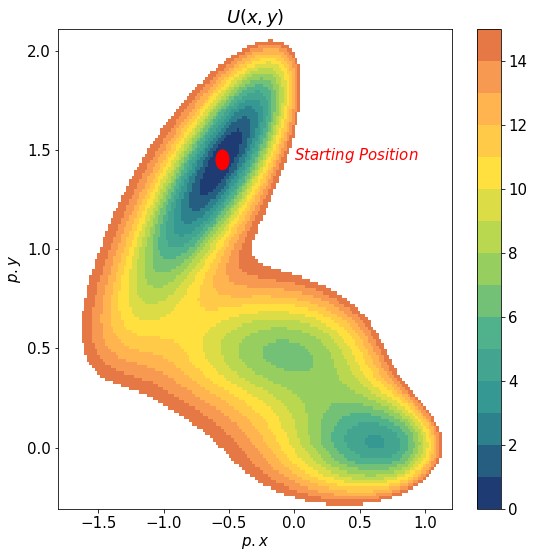

In [3]:
#-- MULLER --#
#-- prepare grid points
y = np.linspace(-0.3,2.1,150)
x = np.linspace(-1.8,1.2,150)
X, Y = np.meshgrid(x, y)
Z = Mullerfunction(X,Y)
#-- set to 0 the lowest basin --#
Z-=np.min(Z)

fig,ax = plt.subplots(figsize=(8,8)) 
#-- color map initialization --#
bounds = np.arange(0, 16, 1.)
cmap = plt.cm.get_cmap('fessa',len(bounds))
colors = list(cmap(np.arange(len(bounds))))
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over("white")
c = plt.pcolormesh(X, Y, Z, cmap=cmap,shading='auto',alpha=1,zorder=-1,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False)
)
ax.set_xlabel(r"$p.x$")
ax.set_ylabel(r"$p.y$")
ax.set_title(r'$U(x,y)$')

#-- highlight the starting point --#
ax.text(0,1.45,r'$Starting$ $Position$',color="red")
draw_circle = plt.Circle((-0.55,1.45), 0.05, color="red")
ax.add_artist(draw_circle)

fig.colorbar(c, ax=ax)
plt.tight_layout()

# Prepare input files for plumed

In [4]:
folder = "unbias/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

# using natural units for Toy Model 
UNITS NATURAL

# compute position for the one particle  
p: POSITION ATOM=1
# adding external potential 
potential: CUSTOM ARG=p.x,p.y FUNC="""+Mullerpot(),""" PERIODIC=NO
ene: BIASVALUE ARG=potential

# Print 
# STRIDE=200 so that time is in 1 step
PRINT FMT=%g STRIDE=200 FILE=COLVAR ARG=p.x,p.y,ene.bias

ENDPLUMED
""",file=file)

#-- write input files for ves module --#
generate_input_file(name_file=folder+"input",nstep=sim_parameters["nstep"],temp=sim_parameters["temp"],
                    friction=sim_parameters["friction"],random_seed=sim_parameters["plumedseed"],
                    initial_position=sim_parameters["initial_position"])
write_coeff("0",folder+"input")

#-- move necessary files for ves module --#
#execute("mv pot_coeffs_input.data unbias",folder=".")
#-- run plumed --#
#execute("plumed ves_md_linearexpansion input",folder=folder)

## Unbias Trajectory 

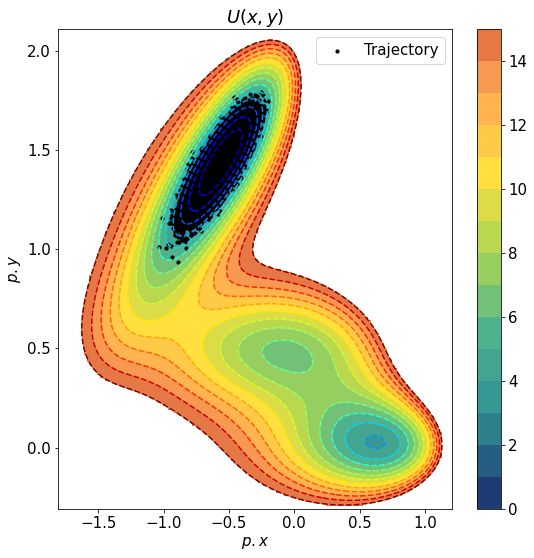

In [5]:
fig, ax = plt.subplots(figsize=(8,8))

x,y = load_dataframe("unbias/COLVAR").filter(regex="^p.x").values,load_dataframe("unbias/COLVAR").filter(regex="^p.y").values
ax.scatter(x,y,color="black",alpha=1,label="Trajectory",s=10)

#-- prepare grid points
y = np.linspace(-0.3,2.1,150)
x = np.linspace(-1.8,1.2,150)
X, Y = np.meshgrid(x, y)
Z = Mullerfunction(X,Y)
#-- set to 0 the lowest basin --#
Z-=np.min(Z)

#bounds = np.arange(np.min(Z), np.max(Z), 5.)
bounds = np.arange(0, 16, 1.)
cmap = plt.cm.get_cmap('fessa',len(bounds))
colors = list(cmap(np.arange(len(bounds))))
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over("white")

c = plt.pcolormesh(X, Y, Z, cmap=cmap,shading='auto',alpha=1,zorder=-1,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False)
)
c = plt.contourf(X, Y, Z, bounds , cmap=cmap,shading='auto',alpha=1,zorder=-1, linewidth=10,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="Energu Surface"
)
fig.colorbar(c, ax=ax)
c = plt.contour(X, Y, Z, bounds , cmap="jet",shading='auto',alpha=1, linewidth=5, linestyles="dashed")
#-- if put label on isolines --#
#c.clabel()

ax.legend()
ax.set_xlabel(r"$p.x$")
ax.set_ylabel(r"$p.y$")
ax.set_title(r'$U(x,y)$')
plt.tight_layout()

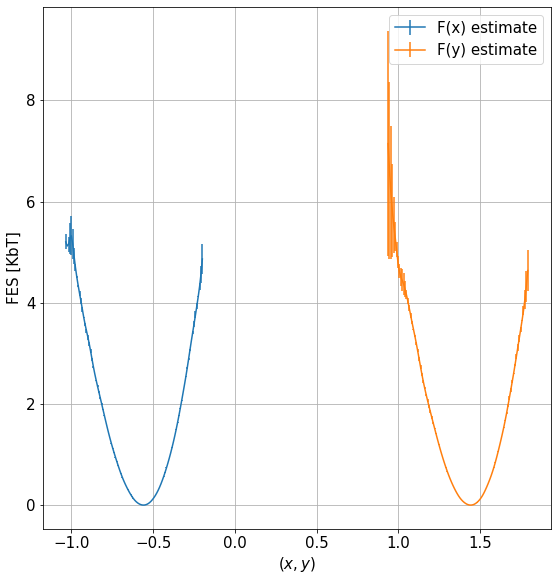

In [6]:
#-- estimation of Free Energy Surface --#
s = load_dataframe("unbias/COLVAR").filter(regex="^p").to_numpy()
logweight=np.zeros(s.shape[0])

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(x) estimate","F(y) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(x,y)$")
ax.set_ylabel("FES [KbT]")

plt.show()

## Unbias simulation DeepTICA Analysis and Export  
  
Before performing the training we have to choose the `lag_time`. How to do that?  

### Theoretical Framework, TICA time-lagged independent component analysis  

From a *Molecular Dynamics* simulation we obtain a set of points $\left\{ \vec {x}(t_i), \vec {p}(t_i) \right\} _{i=1,N}$ which define a trajectory in the Phase Space $\Omega$ of the system, where $N$ is the total number of simulation steps.  
These points are distributed according to a certain probability distribution $p_t(\vec x)$. If the simulation is sufficiently long and the system is ergodic then (in the canonical ensemble NPT) $p(\vec x) = \dfrac{e^{-\beta U(\vec x)}}{Z}$ is the Boltzmann one. Strictly speaking we can say that during the simulation the distribution probability evolves in time and the stationary distribution $\mu (\vec x)$ is the Boltzmann distribution: $\lim_{\tau \rightarrow \infty} p_{t+\tau}(\vec x)  = \mu (\vec x)$  

#### Transfer operator
It is possible to formalize this statement by the definition of the transfer operator $\mathcal{T}(\tau)$: given a $p_t(\vec x)$ then $p_{t+\tau}(\vec x) = \mathcal{T}(\tau) \circ p_t(\vec x)$  
Denoting with $\psi_i(\vec x)$ its eigenfunctions, and with $\lambda_i(\tau) = e^{-\frac{\tau}{t_i}}$ its eigenvalues it is possibile to rewrite the expression above as follows: $$ p_{t+\tau}(\vec x) = \mathcal{T}(\tau) \circ p_t(\vec x) = \sum_i e^{-\frac{\tau}{t_i}} \langle p_t(\vec x) \psi_i(\vec x) \rangle \psi_i(\vec x) $$
As $\tau \rightarrow \infty$ all the contributes vanish but the one relative to $t_i \rightarrow \infty$ which is exactly the Boltzmann distribution $\mu(\vec x)$, the fixed point of $\mathcal{T}(\tau)$, $\mathcal{T}(\tau) \circ \mu(\vec x) = \mu (\vec x)$  
  
#### TICA Analysis  
The aim of TICA analysis is to diagonalize $\mathcal{T}(\tau)$ and express its action on a probability distribution through its eigenfunctions and eigenvalues. In this way by applying infinite times $\mathcal{T}(\tau)$ to $p_t(\vec x)$ one finally obtain the form of $\mu (\vec x)$:
$$ \lim_{k \rightarrow \infty} \left( \prod^k \mathcal{T}(\tau) \right) \circ p_t(\vec x) =\lim_{k \rightarrow \infty} \mathcal{T}(k \tau) p_t(\vec x) = \lim_{k \rightarrow \infty} p_{t+k \tau} (\vec x) = \lim_{k \rightarrow \infty} \sum_i e^{-\frac{k \tau}{t_i}} \langle p_t(\vec x) \psi_i(\vec x) \rangle \psi_i(\vec x) = \mu (\vec x) $$  
Where $ \langle p_t(\vec x) \psi_i(\vec x) \rangle = \int d \vec x p_t(\vec x) \psi_i(\vec x) e^{-\beta U(\vec x)} $  
In order to diagonalize this operator we must consider a subset of the all eigenfunctions, such that we can work in a finite dimensional vector space. Suppose we are interested in the first $m$ slow modes of the system. With this choice we are assuming that all the other slow modes are those with a timescale much smaller than $\tau$: $e^{-\frac{\tau}{t_i}} \rightarrow 0$, for $i>m$.  
Then it is clear that $\tau$ defines which are the slow modes we are interested in. But in principle we do not know the slow modes of the system and their timescales.  

#### Linear approximation and TICA
How can we guess the $\psi_i(\vec x)$ ? 
To answer this question we first recall what TICA does:   
It uses a linear transformation to map an original order parameters $d_j(\vec x)$ set to a new set of order parameters $\psi_i(\vec x)$, the *Independent component*. $\psi_i(\vec x)$ must fullfill two properties:  
1.  they are uncorrelated. This means that $\langle \psi_i(\vec x_t) \psi_j(\vec x_{t} \rangle = \delta_{i,j}$
2.  Their autocovariances at a fixed lag time $\tau$ are maximal  
If $\psi_i(\vec x)$ are the $\mathcal{T}(\tau)$ eigenfunctions, then $$\langle \psi_i(\vec x_t) \psi_i(\vec x_{t+\tau}) \rangle = \lambda_i$$  
  
We consider a basis set formed by the so called *descriptors* $d_j(\vec x)$, $\left\{ d_j(\vec x) \right\}_{j=1,n}$. Then we assume that each $\psi_i(\vec x)$ can be written as a linear combination of $\{d_j(\vec x)\}$: $\psi_i(\vec x) = \sum_j^n b_{ij} d_j(\vec x)$  
With this approximation the problem of finding $\psi_i(\vec x)$ (of maximizing $\lambda_i$) becomes a general eigenvalue problem to find $b_{ij}$: $$C^d(\tau) \cdot \vec b_i = \lambda_i C^d(0) \cdot \vec b_i$$
where $C_{ij}^d(\tau) = \langle d_i(\vec x_t) d_j(\vec x_{t+\tau})  \rangle$ and $C_{ij}^d(0) = \langle d_i(\vec x_t) d_j(\vec x_{t})  \rangle$  
  
Condition 1. requires that there is not overlap between $\lambda_i$ and $\lambda_j$, and that $C^d(\tau)$ is symmetric. Obviously this condition it is not satisfied from the data, which are obtained from an finite simulation, so we must enforce this condition.  

#### Finally, how to choose $\tau$ 
The choice of $\tau$ is strictly related to the timescales of the slow modes we are interested in. In addition due to the condition 2. we do not want overlap between eigenvalues. This mean that in generale to choose really small o really large $\tau$ it is not a wise choice. Physically speaking choosing a really small value for $\tau$ means that all the slow modes are *slow*, and it becomes difficult to distinguish them. While choosing a very large value for $\tau$ means that all the slow modes are *fast* and their eigenvalues will vanish. Every value of $\tau$ in this interval would be ok in principle.. but what does it mean *small* and *large*?  
  
One possibility is to look directly at the time auto-correlation function $acorr(\tau)$ of the descriptors $d_j(\vec x)$, and from it one can estimate their correlation length $\xi$, also called *memory timescale*. When the simulated system is in equilibrium one can expect that the time auto-correlation function decays as an exponential $e^{-\frac{\tau}{\xi}}$. In this case $\xi$ can be estimated by fitting $acorr(\tau)$. But I will use a more generale definition of $\xi$, which will give us a better estimation: $\xi = \int d \tau acorr(\tau)$
  
### Time auto-correlation function of the descriptors  

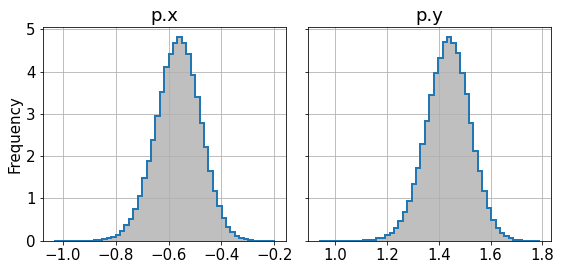

In [110]:
data = load_dataframe("unbias/COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
    ax.set_title(desc)

plt.tight_layout()

autocorrelation for  p.x
autocorrelation for  p.y


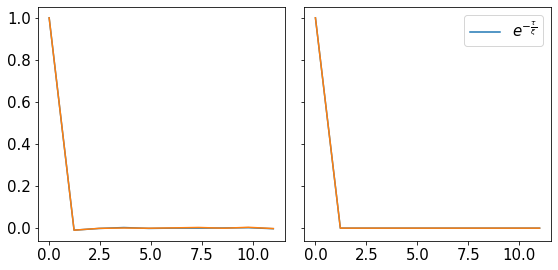

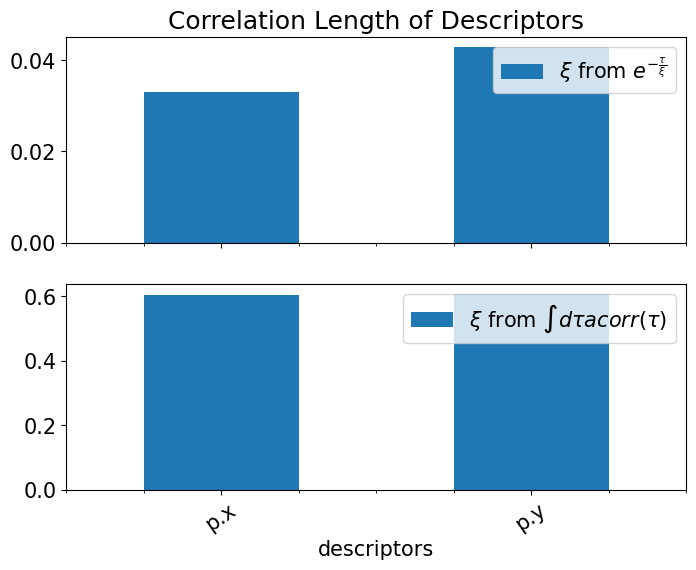

0.6073646199152487
0.6022168642081687


In [8]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

#-- unit of step --#
last=10
x = np.linspace(0,last+1,last)
acorr = np.empty(last)
corr_length = np.empty(len(descriptors_names))
timescale = np.empty(len(descriptors_names))
k=0

for desc in descriptors_names:
    print("autocorrelation for ", desc)
    for i in range(last):
        acorr[i] = data[desc].autocorr(i)
    p_opt,p_cov = curve_fit(f,x[:last],acorr[:last],maxfev=2000)
    corr_length[k] = p_opt[0]
    f_fit = f(x[0:last],p_opt[0])
    axs[0].plot(x,acorr)
    axs[1].plot(x,f_fit)
    timescale[k] = integrate.trapz(acorr[:last],x[:last])

    k+=1
axs[1].legend([r"$e^{-\frac{\tau}{\xi}}$"])
plt.tight_layout()

fig,ax = plt.subplots(2,1,figsize=(8,6),dpi=100,sharex=True)

times = pd.DataFrame(descriptors_names,columns=["descriptors"])
times["timescale"] = timescale
times.plot(kind="bar",x="descriptors",y="timescale",rot=35,ax=ax[1],fontsize=15,label=r"$\xi$ from $\int d\tau acorr(\tau)$")

c_length = pd.DataFrame(descriptors_names,columns=["descriptors"])
c_length["cor_len"] = corr_length
c_length.plot(kind="bar",x="descriptors",y="cor_len",rot=35,ax=ax[0],fontsize=15,label=r"$\xi$ from $e^{-\frac{\tau}{\xi}}$")

ax[0].set_title('Correlation Length of Descriptors')

plt.show()

print(np.max(timescale))
print(np.min(timescale))

The two $\xi$ are almost the same, as expected from an unbias simulation with no transitions between basins.  
The found value tells us that a good chioce for $\tau$ is around $0.6$, not much smaller and not much bigger.  
I choose $\tau=1$

In [9]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 2
train_parameters = {
              'descriptors': '^p.',
              'nodes':[n_input,10,n_output], 
              'activ_type': 'tanh',
              'lag_time':1,
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.8,
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':2000,
              'earlystop':True,
              'es_patience':50,
              'es_consecutive':False,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':10,
              #if reweight the timescale
              "reweighting": False,
              }
#--------------------------------------#

## Train Deep-TICA useful functions in utils  
  
```py
def train_deeptica_load(temp=1.0,lag_time=10,path="colvar.data",descriptors="^p.",trainsize=0.8,reweighting=True):
    
    data = load_dataframe(path)
    
    search_values=descriptors
    search_names=descriptors
    X, names, t = data.filter(regex=search_values).values, data.filter(regex=search_names).columns.values, data['time'].values
    n_features = X.shape[1]
    
    if reweighting:
        # Compute logweights for time reweighting
        logweight = data.["opes.bias"].to_numpy()
        #-- the logweights are V(x,y)/T --#
        logweight = logweight/temp
    else:
        print("no weights")
        logweight=None
          
    dataset = create_time_lagged_dataset(X,t=t,lag_time=lag_time,logweights=logweight)
    n_train  = int( trainsize * len(dataset) )
    n_valid  = len(dataset) - n_train
    train_data, valid_data = random_split(dataset,[n_train,n_valid])

    # create dataloaders
    train_loader = FastTensorDataLoader(train_data, batch_size=len(train_data))
    valid_loader = FastTensorDataLoader(valid_data, batch_size=len(valid_data))

    print('Time-lagged pairs:\t',len(dataset))
    print('Training data:\t\t',len(train_data))
    print('Validation data:\t',len(valid_data))

    return data,logweight,train_loader,valid_loader,X

def training(temp,path,train_parameters):

    data,logweight,train_loader,valid_loader,X = train_deeptica_load(temp=temp,lag_time=train_parameters["lag_time"],
                                                                    path=path,descriptors=train_parameters["descriptors"],
                                                                    trainsize=train_parameters['trainsize'],
                                                                    reweighting=train_parameters['reweighting'])
    # DEVICE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # MODEL
    model = DeepTICA_CV(train_parameters['nodes'],activation=train_parameters['activ_type'])
    model.to(device)

    # OPTIMIZER (Adam)
    opt = torch.optim.Adam(model.parameters(), lr=train_parameters['lrate'], weight_decay=train_parameters['l2_reg'])

    # REGULARIZATION
    model.set_optimizer(opt)
    model.set_earlystopping(patience=train_parameters['es_patience'],
                            min_delta=0.,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False)

    # TRAIN
    model.fit(train_loader,valid_loader,
        standardize_inputs=train_parameters['standardize_inputs'],
        standardize_outputs=train_parameters['standardize_outputs'],
        loss_type=train_parameters['loss_type'],
        n_eig=train_parameters['n_eig'],
        nepochs=train_parameters['num_epochs'],
        info=False, log_every=train_parameters['log_every'])

    return model,data,logweight,X
```

## DeepTICA Analysis and Export

In [10]:
torch.manual_seed(21)
model,data,logweight,X = training(sim_parameters["temp"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- export checkpoint (for loading the model back to python) and torchscript traced module --#
save_folder = folder+"deeptica/"
try:
    os.mkdir(save_folder)
except:
    print("already exists")
#-- move to cpu before saving results --#
model.to("cpu")
model.export(save_folder)
print("model saved")

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())

no weights
Time-lagged pairs:	 249998
Training data:		 199998
Validation data:	 50000
Epoch Train Loss  Valid Loss  Eigenvalues             
10    0.004       0.002       0.004  -0.011 
20    0.002       0.001       0.005  -0.012 
30    0.002       0.001       0.005  -0.012 
40    0.004       0.003       0.005  -0.012 
50    0.005       0.004       0.005  -0.012 
INFO: Early stopping
57    0.006       0.004       0.005  -0.012 
model saved
timescales:  [0.19089216        nan]
eigenvalues:  [ 0.0053079  -0.01156356]


## Load existing model  
  
It is possible to load an existing model  

```py
data = load_dataframe(folder+"COLVAR")
search_values="^p."
X, t, logweight = data.filter(regex=search_values).values, data['time'].to_numpy(). data["opes.bias"].to_numpy()

logweight = ( logweight-max(logweight) ) / sim_parameters["temp"]

model = DeepTICA_CV(train_parameters["nodes"],activation=train_parameters['activ_type'])
model.load_checkpoint(folder+"deeptica/model_checkpoint.pt")
```

#### Adding to data the cvs values

In [11]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

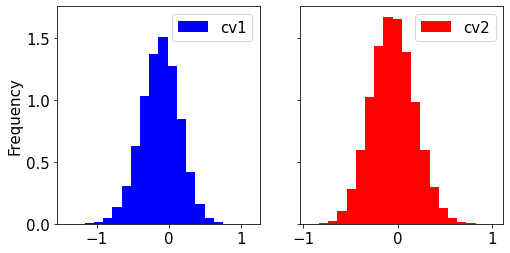

In [109]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")

### FES estimate from cvs  
Obviously from this first simulation it is not possible to found a cvs that from data are able to distinguish all the possible basins. I recall that our approach is a **data drive approach**.  


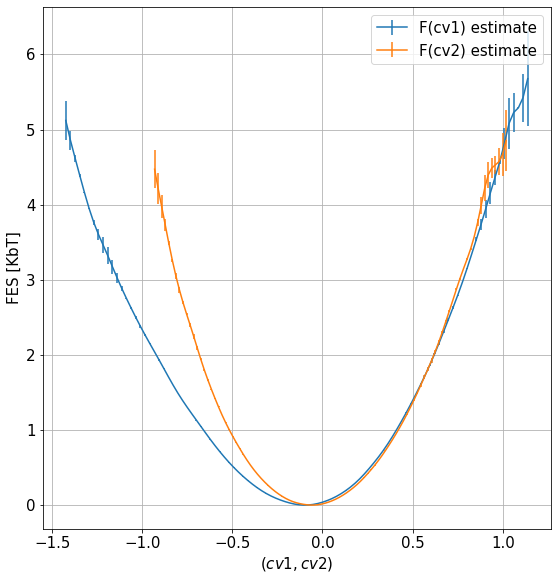

In [18]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()
logweight=np.zeros(s.shape[0])

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [KbT]")

plt.show()

### Isolines  
We are working with a two dimensional Potential, and we are using as descriptors the two cartesian coordinates. This allows us to plot the isolines of the cvs on the physical space $(x,y)$    

In [111]:
def plot_cvs_isolines(model,limits,points=150,n_out=2,scatter=None,axs=None):

    #-- prepare grid --#
    xx,yy = np.meshgrid(np.linspace(limits[0][0],limits[0][1],points),np.linspace(limits[1][0],limits[1][1],points))
    grid = np.transpose(np.array([xx.reshape(points*points),yy.reshape(points*points)]))

    #-- evaluate cvs on the grid --#
    cvs = []
    for i in range(n_out):
        cvs.append(np.transpose(model(torch.Tensor(grid)).detach().cpu().numpy())[i].reshape(points,points))

    #-- plotting --#
    if axs is None:
        fig,axs = plt.subplots(1,n_out,figsize=(12,6))

    for k,ax in enumerate(axs):
        cset = ax.contourf(xx,yy,cvs[k],linewidths=1,cmap="fessa")
        cset = ax.contour(xx,yy,cvs[k],linewidths=3,cmap="gray",linestyles="dashed")
        ax.clabel(cset,inline=True,fmt='%1.1f',fontsize=15)
        ax.set_xlabel("p.x")
        ax.set_ylabel("p.y")
        ax.set_title('Deep-TICA '+str(k+1))
        if scatter is not None:
            ax.scatter(scatter[:,0],scatter[:,1],s=2,c='white',alpha=0.8)
            ax.set_aspect('equal')
        
    plt.tight_layout()
    plt.show()

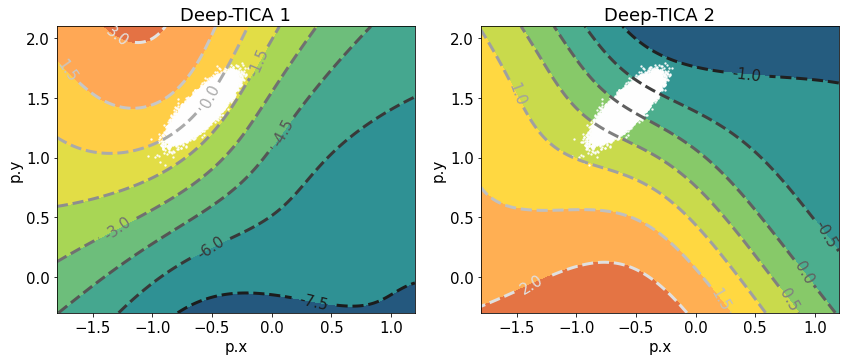

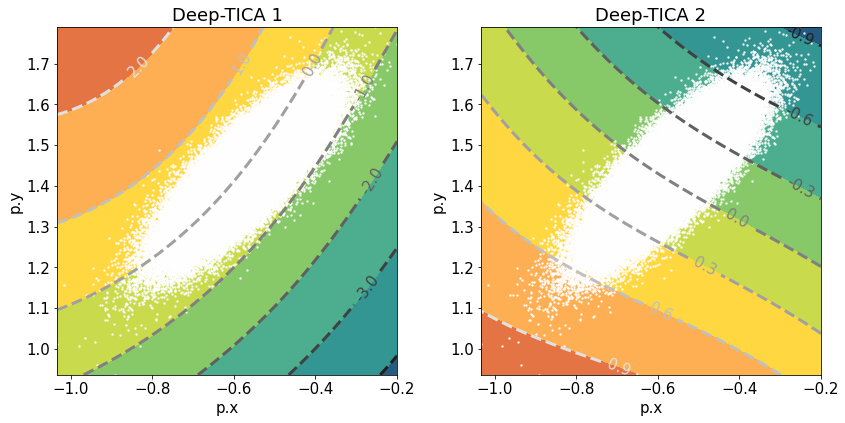

In [112]:
plot_cvs_isolines(model,limits=((-1.8,1.2),(-0.3,2.1)),scatter=X)
lim = ((np.min(X[:,0]),np.max(X[:,0])),(np.min(X[:,1]),np.max(X[:,1])))
plot_cvs_isolines(model,limits=lim,scatter=X)

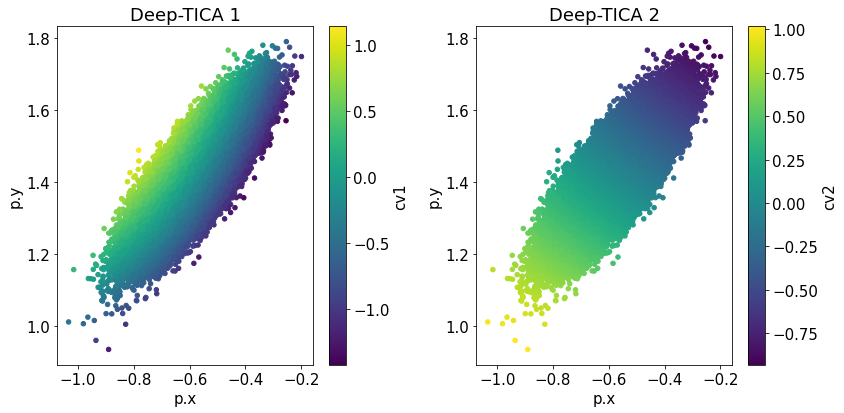

In [103]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="p.y",x="p.x",c="cv"+str(k+1),cmap="viridis",ax=ax)
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

## $\Delta F$

In [ ]:
'''
copydata = data[1:]
CLEAR=5000

#from scipy import integrate
import scipy.integrate
deltaf = np.empty(0)
for el in np.arange(CLEAR,len(copydata)+CLEAR,CLEAR):
    s = copydata[:el][["p.x","p.y"]].to_numpy()
    #s = el[["cv"+str(it-1)+".node-0","cv"+str(it-1)+".node-1"]].to_numpy()
    logweight = copydata[:el]["opes.bias"].to_numpy()/sim_parameters["temp"]
    fes,grid,bounds,error = compute_fes(s[:,0], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=1,
                                        bandwidth=0.02,scale_by='range',
                                        plot=False)

    #-- per cv1 --#
    #ind1 = (grid<0.1) & (grid>-1)
    #ind2 = (grid<1) & (grid>0.1)
    #-- per x --#
    ind1 = (grid<1) & (grid>0)
    ind2 = (grid<0) & (grid>-1.3)
    s1 = grid[ ind1 ]
    s2 = grid[ ind2 ] 
    I1 = scipy.integrate.trapz(np.exp(-fes[ind1]/sim_parameters["temp"]), s1)
    I2 = scipy.integrate.trapz(np.exp(-fes[ind2]/sim_parameters["temp"]), s2)
    
    #print(I1,I2)
    deltaf = np.append(deltaf,-sim_parameters["temp"]*np.log(I1/I2))
#print(deltaf)
plt.plot(np.arange(len(deltaf)),deltaf)
'''